In [5]:
# Import what we need

#Modify the PATH accordingly to import colloids
colloids_path = '/Volumes/exp/code_pink/colloids/python/'
tracking_path = '/Volumes/exp/code_pink/'

import os
import sys
if colloids_path not in sys.path:
    sys.path.append(colloids_path)
if tracking_path not in sys.path:
    sys.path.append(tracking_path)

from colloids import track, lif
from contact_tracking.src import read_lif, menus
from explore_lif import Reader
import nplocate as nl

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import pylab as pl
from PIL import Image
from copy import deepcopy
from scipy import signal
# from contact_tracking.src import properties, figures
import os

from scipy import ndimage, interpolate
def hist_match(image, bins=100, axes=None):
    """
    Matching the intensity distribution of each slice along all axes
    This functions is designed to fix the slice-by-slice intensity drift in the
        3D confocal image.

    Args:
        image (numpy.ndarray): a N-Dimensional Image.
        bins (int): the number of bins to approximate the probability distribution
            function (PDF) of the intensities
        axes (none or iterable): the order of the axes, along which to perform
            the histgoram matching

    Return:
        numpy.ndarray: The image whose intensities were fixed.
    """
    new_image = image.copy()
    if isinstance(axes, type(None)):
        axes = np.arange(image.ndim)
    for axis in axes:
        new_image = hist_match_1d(new_image, axis=axis, bins=bins)
    return new_image


def hist_match_1d(image, axis, bins=100):
    """
    Matching the intensity distribution of each slice along one axis, to match
        the overall distribution.
    This functions is designed to fix the slice-by-slice intensity drift in the
        3D confocal image.

    Args:
        image (numpy.ndarray): a N-Dimensional Image.
        axis (int): the index of axis along which the histogram matching would
            be performed.
        bins (int): the number of bins to approximate the probability distribution
            function (PDF) of the intensities

    Return:
        numpy.ndarray: The image whose intensities were fixed.
    """
    new_image = image.copy()
    new_image -= new_image.min()
    # generate the bins
    if isinstance(bins, int):
        bins = np.linspace(0, image.max(), bins)
    bc = (bins[1:] + bins[:-1]) / 2  # bin center
    bw = bins[1:] - bins[:-1]  # bin width

    # calculate the pdf and cdf from the entire image
    hist, _ = np.histogram(new_image.ravel(), bins=bins, density=True)
    pdf = hist / hist.sum()
    cdf = np.cumsum(pdf)
    cdf /= cdf.max()

    bc = np.concatenate((np.zeros(1), bc, np.ones(1) * new_image.max()))
    cdf = np.concatenate((np.zeros(1), cdf, np.ones(1)))

    old_intensities = bc.copy()
    is_zero = np.isclose(old_intensities, 0)
    old_intensities[is_zero] = np.inf

    for s in range(new_image.shape[axis]):
        # calculate the cdf of pixel intensities of one slice
        slices = [slice(None) for s in range(new_image.ndim)]
        slices[axis] = s
        img_slice = new_image[tuple(slices)]
        hist_slice, _ = np.histogram(img_slice, bins=bins, density=True)
        pdf_slice = hist_slice / hist_slice.sum()
        cdf_slice = np.cumsum(pdf_slice)
        cdf_slice /= cdf_slice.max()
        cdf_slice = np.concatenate((np.zeros(1), cdf_slice, np.ones(1)))

        # interpolate the cdf of the target distribution
        f = interpolate.interp1d(y=bc, x=cdf, fill_value=0)
        new_intensities = f(cdf_slice)
        ratio = new_intensities / old_intensities

        indices = np.digitize(img_slice, bins=bins) - 2
        new_image[tuple(slices)] = img_slice * np.take(ratio, indices)

    return new_image

def Blur(img):
    img_med = ndimage.median_filter(img, 3)
    img_blur = ndimage.gaussian_filter(img_med, 3)
    return img_blur

def find_nan(tracked_centers):
    nan_li = []
    for i in range(len(tracked_centers)):
        if np.isnan(tracked_centers[i]).any():
            nan_li.append(i)
    nan_li = np.array(nan_li)
    new_centers = np.delete(np.array(tracked_centers),nan_li,0)
    return new_centers,nan_li                                                      

def xyz_gr(xyz,name,path):
    pcen = np.loadtxt(xyz, delimiter='\t',skiprows=2, usecols=[1, 2, 3, 4])

    centres =  pcen[:,:3] ##remove small errored particles from centres and then get gr
    diameter = np.mean(pcen[:,3])*2 ##diameter is from tracking results mean

    gr = nl.get_gr(positions=centres, cutoff=diameter * 7, bins=200)

    gr_ = np.vstack((gr[0],gr[1]))
    gr_ = gr_.T
    np.savetxt(path+name+'_gr.txt',gr_)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import matplotlib.pyplot as plt
import numpy as np
font = {'family' : 'Times',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [7]:
import scienceplots

plt.style.use('science')
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

In [4]:
folder = '/Users/zf19684/Desktop/code_pink/chapter5/300px_inuse/gr/'

In [15]:
## Get a decon tif file and get their names 
folder = '/Volumes/exp/Confocal/Emulsions/2022/20220921/ml2-1/'
# xyz_path = '/Users/zf19684/Desktop/code_pink/300px_inuse/xyz/30-350px/'
# img_path = '/Volumes/Paris/Paddy/Contacts/Original_image/'
out_folder = '/Volumes/exp/Confocal/Emulsions/2022/20220921/ml2-1/'
px=0.09

In [9]:
tiff_img = Image.open(folder+'ml2_T0.tif')

(512, 512, 1525)
(2252, 3) (2076, 3)


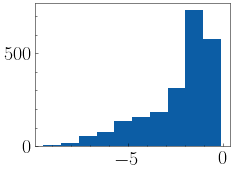

In [14]:
# track single image set

tiff_img = Image.open(folder+'ml2_T0.tif')

img = []
for z in range(tiff_img.n_frames):
    tiff_img.seek(z)
    data = tiff_img.convert('L')
    img.append(np.array(data))
img = np.array(img)
img = np.moveaxis(img, 0, -1) # 在这里，img的x和z被互换了，in the order of xyz
print(img.shape) # in xyz order

# hist matching
img_ = hist_match(img, bins=100, axes=None)
img_ = Blur(img)

## track particles
finder = track.MultiscaleBlobFinder(shape=img_.shape,Octave0=False)
features = finder(img_)
z, y, x, radii, response = features.T
centres = np.array((x, y, z)).T

plt.hist(response)

response_threshold = -0.5
centres_refined = centres[response < response_threshold]
print(centres.shape, centres_refined.shape)

features = features[:, :4][response < response_threshold]
#     rescaled = features[:, :4]/(2*radii.mean())
## save xyz file
nl.save_xyz(out_folder + 'T0.xyz', [features[:, :4]])

(512, 512, 1525)
(2546, 3) (2452, 3)
(512, 512, 1525)
(2705, 3) (2567, 3)
(512, 512, 1525)
(2843, 3) (2831, 3)
(512, 512, 481)
(2877, 3) (2874, 3)
(512, 512, 481)
(2891, 3) (2884, 3)
(512, 512, 481)
(2969, 3) (2965, 3)


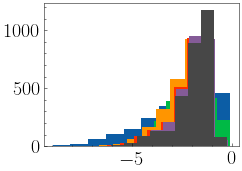

In [20]:
# this is for tracking a time seris of xyz 
for t in range(1,7):
    tiff_img = Image.open(folder
                      +'ml2_T'+str(t)+'.tif')

    img = []
    for z in range(tiff_img.n_frames):
        tiff_img.seek(z)
        data = tiff_img.convert('L')
        img.append(np.array(data))
    img = np.array(img)
    img = np.moveaxis(img, 0, -1) # 在这里，img的x和z被互换了，in the order of xyz
    print(img.shape) # in xyz order

    # hist matching
    img_ = hist_match(img, bins=100, axes=None)
    img_ = Blur(img)

    ## track particles
    finder = track.MultiscaleBlobFinder(shape=img_.shape,Octave0=False)
    features = finder(img_)
    z, y, x, radii, response = features.T
    centres = np.array((x, y, z)).T

    plt.hist(response)

    response_threshold = -0.5
    centres_refined = centres[response < response_threshold]
    print(centres.shape, centres_refined.shape)
    
    features = features[:, :4][response < response_threshold]
#     rescaled = features[:, :4]/(2*radii.mean())
## save xyz file
    nl.save_xyz(out_folder + str(t) + '.xyz', [features[:, :4]])

0.35
(512, 512, 512)
(3060, 3) (2982, 3)


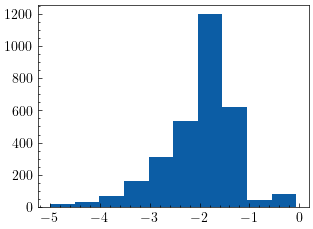

In [122]:
# filen = ['fp3','fp4','pl1'] ##'pl2','ap8'
# cps = ['0.16','0.20','0.35'] ##'0.09','0.07'
cps = ['0.35']
for cp in (cps):
    print(cp)
    
##pl2 ap8的tracking不好因为drifting

for cp in (cps):
    tiff_img = Image.open(img_path
                      +cp+'_decon_centers.tif')

    img = []
    for z in range(30,542):
        tiff_img.seek(z)
        data = tiff_img.convert('L')
        img.append(np.array(data))
    img = np.array(img)
    img = np.moveaxis(img, 0, -1) # 在这里，img的x和z被互换了，in the order of xyz
    print(img.shape) # in xyz order

    # hist matching
    img_ = hist_match(img, bins=100, axes=None)
    img_ = Blur(img)

    ## track particles
    finder = track.MultiscaleBlobFinder(shape=img_.shape,Octave0=False)
    features = finder(img_)
    z, y, x, radii, response = features.T
    centres = np.array((x, y, z)).T

    plt.hist(response)

    response_threshold = -0.5
    centres_refined = centres[response < response_threshold]
    print(centres.shape, centres_refined.shape)
    
    features = features[:, :4][response < response_threshold]
#     rescaled = features[:, :4]/(2*radii.mean())
## save xyz file
    nl.save_xyz(xyz_path + cp + '_512px.xyz', [features[:, :4]])

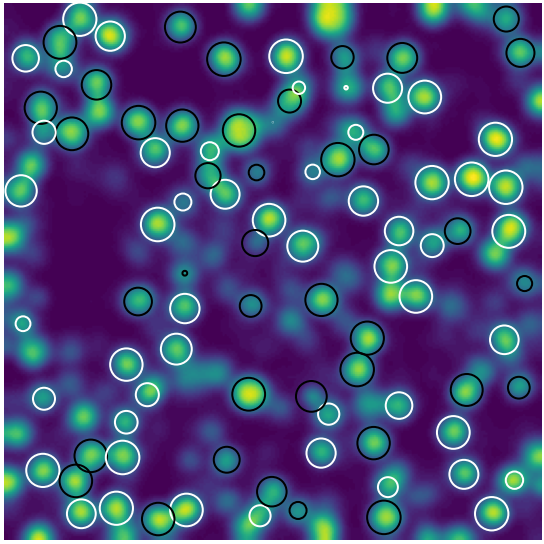

In [28]:
nl.see_slice(img_, centres_refined, s=50, radius=8, axis=2) ##img is in xyz, centres is in zyx
# plt.savefig(out_folder+cp+'tracking.png')

In [39]:
#mean polydispersity
std_p = np.std(myarray)
pd = std_p / myarray.mean()
print('mean:%s'%np.mean(features[:,3]*px*2))
print ('polydispersity:%s'%(pd))

mean:2.70824907480313
polydispersity:0.10125439582549518


Text(0, 0.5, 'P($\\sigma$)')

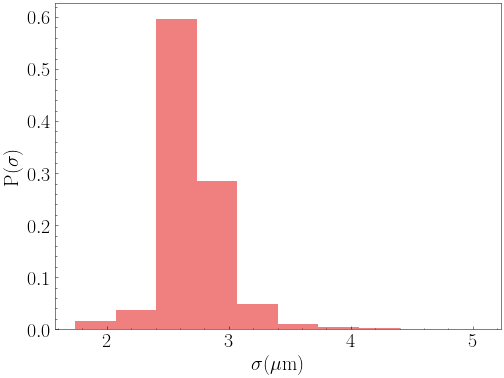

In [37]:
fig = plt.figure(figsize=(8,6))

myarray = features[:,3]*px*2 
weights = np.ones_like(myarray)/float(len(myarray))
plt.hist(myarray, weights=weights,color='lightcoral')


plt.xlabel(r'$\sigma (\mu$m)')
plt.ylabel(r'P($\sigma$)')

In [125]:
# assign directory
directory = xyz_path
 
for filename in os.listdir(directory):
    if '512px.xyz' in filename:
        name = filename[:4]
        xyz_gr(xyz_path+filename,name,xyz_path) ##input xyz,name,path, output savetxt(path+name+'_gr.txt',gr_)  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nplocate/utility.py:130: RuntimeWarning: invalid value encountered in true_divide
  hist = hist / rg_hist


In [17]:
xyz_path

'/Volumes/exp/code_pink/Mytrack/notebooks/data/'

## Done!

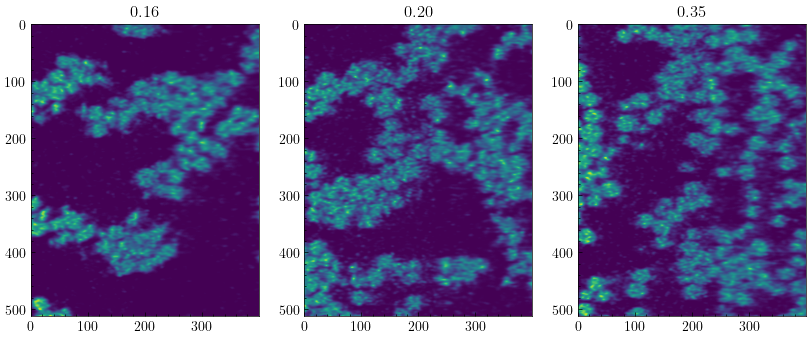

In [112]:
## check original images

folder = '/Volumes/Paris/Paddy/Contacts/Original_image/'
i=0
z=50
fig,axs = plt.subplots(1,3, figsize = (10,5))
axs = axs.ravel()

for filename in os.listdir(folder):
    if 'decon_centers.tif' in filename and '_0' not in filename:  
        label = filename[:4]
        tiff_img = Image.open(folder+filename)
        img = []
        for z in range(100,500):
            tiff_img.seek(z)
            data = tiff_img.convert('L')
            img.append(np.array(data))
        img = np.array(img)
        img = np.moveaxis(img, 0, -1) 
        axs[i].imshow(img[z, :, :])
        axs[i].set_title(label)
        i = i+1

In [14]:
for filename in os.listdir(folder):
    if 'centers' in filename and '._0' not in filename:  
        print(filename)

pl1_decon_centers.tif
fp3_decon_centers.tif
fp4_decon_centers.tif
pl2_decon_centers.tif
ap8_decon_centers.tif


IndexError: index 349 is out of bounds for axis 2 with size 300

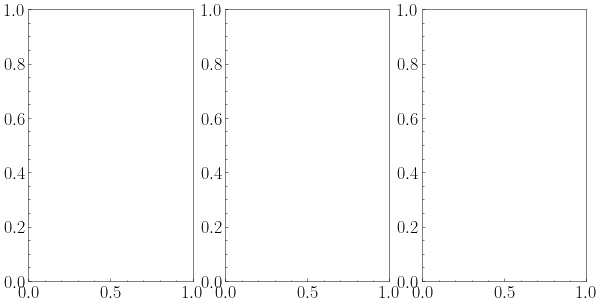

In [16]:
i=0
z=100
fig,axs = plt.subplots(1,3, figsize = (10,5))
axs = axs.ravel()

for filename in os.listdir(folder):
    if 'centers' in filename and '._0' not in filename:  
        label = filename[:4]
        tiff_img = Image.open(folder+filename)
        img = []
        for z in range(50,350):
            tiff_img.seek(z)
            data = tiff_img.convert('L')
            img.append(np.array(data))
        img = np.array(img)
        img = np.moveaxis(img, 0, -1) 
        axs[i].imshow(img[:, :, z])
        axs[i].set_title(label)
        i = i+1

In [21]:
outfolder = '/Users/zf19684/Desktop/code_pink/chapter5/300px_inuse/gr/'

fp4_gr_5.0_0.16.txt
ap8_gr_2.5_0.08.txt
pl2_gr_3.0_0.10.txt
pl1_gr_6.6_0.20.txt
fp3_gr_11_0.35.txt


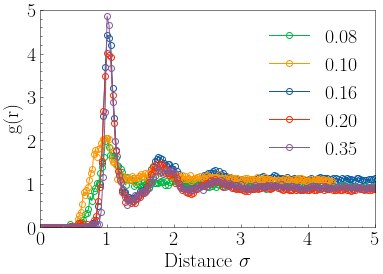

In [23]:
## plot gr together
grs = {}
d_measure = {}
plt.figure(figsize=(6,4))

for filename in os.listdir(folder):
    if '_gr_' in filename:  
        label = filename[-8:-4]
        print(filename)
        data = np.loadtxt(folder+filename)
        X = data[:,0]
        Y = data[:,1]
        zipp = np.array(list(zip(X,Y)))
        grs[label] = zipp ##grs is a dictionary, label is polymer concentration, item is zipped gr
        d_measure[label] = X[np.argmax(Y)]
        plt.plot(X/d_measure[label], Y, marker='o', markerfacecolor='none',label = label)

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
order = [1,2,0,3,4]

#add legend to plot
# plt.legend(frameon=False)

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False)
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Distance $\sigma$')
plt.ylabel('g(r)')
plt.savefig(outfolder+'grs5',transparent=True)

Text(0, 0.5, 'g(r)')

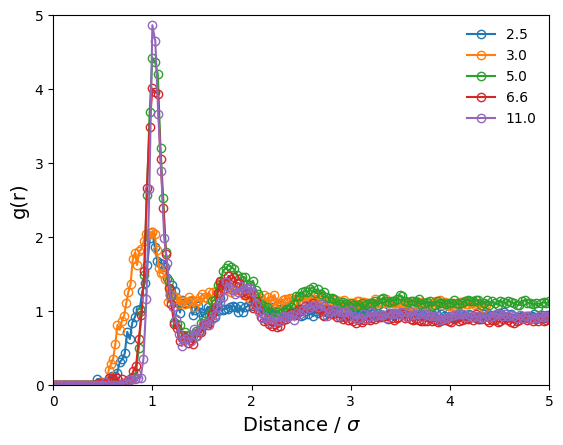

In [21]:
# selected = ['2.5','3.0','5.0','6.6','11.'] ##magnituede over polymer concentration
# labels = ['2.5','3.0','5.0','6.6','11.0']
# for j, i in enumerate(selected):  
#     plt.plot(grs[i][:,0]/d_measure[i], grs[i][:,1], marker='o', markerfacecolor='none',label = labels[j])

# plt.legend(frameon=False)
# plt.xlim(0,5)
# plt.ylim(0,5)
# plt.xlabel('Distance / $\sigma$', fontsize=14)
# plt.ylabel('g(r)', fontsize=14)
# plt.savefig(xyz_path+'grs',transparent=True)